In [1]:
# start by importing a few essential packages
import numpy as np
import matplotlib.pyplot as plt
import astropy

from astropy.io import fits
from astropy.table import Table

In [2]:
# import the constants with the shortcut name const
import astropy.constants as const

# speed of light
print(const.c)


# calculate a speed that is a fraction of the speed of light
const.c * 0.75

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2018


<Quantity 2.24844344e+08 m / s>

In [3]:
import astropy.units as u
     
my_velocity = 100. * u.km / u.s
     
my_velocity

<Quantity 100. km / s>

In [4]:
const.c.to(u.km/u.s)

my_velocity.value

my_velocity.unit

my_velocity / const.c

<Quantity 3.33564095e-07 km / m>

## Part 1: Black Body Spectrum

In [5]:
# Intensity Function

def Intensity(wavelength, T):
    lam = wavelength.to(u.m)
    T = T * u.K
    h, c, kB = const.h, const.c, const.k_B

    x = (h * c / (lam * kB * T)).to_value(u.dimensionless_unscaled)  
    inv_expm1 = np.empty_like(x, dtype=float)


    # The reason for me doing this, is because even if I can directly compute it,
    # It always report some sort of problems, so I search for a solution online
    mask_small = x < 1e-3
    mask_large = x > 100.0
    mask_mid   = ~(mask_small | mask_large)

    xs = x[mask_small]
    inv_expm1[mask_small] = (1/xs) - 0.5 + (xs/12.0) - (xs**3)/720.0

    xl = x[mask_large]
    inv_expm1[mask_large] = np.exp(-xl)

    xm = x[mask_mid]
    inv_expm1[mask_mid] = 1.0 / np.expm1(xm)

    answer = (2 * h * c**2 / lam**5).to(u.W / u.m**3) 
    return answer * inv_expm1                                  


In [6]:
# Bolometric Flux

def Bolometric_Flux(Temp, lam_min=1e-9*u.m, lam_max=1e-2*u.m, n=20000):
    
    lam = np.logspace(np.log10(lam_min.to_value(u.m)),
                      np.log10(lam_max.to_value(u.m)),
                      n) * u.m
    B = u.Quantity([Intensity(l, Temp) for l in lam])   

    # ∫ B_λ dλ → W m^-2
    integral = np.trapezoid(B.value, lam.to_value(u.m)) * (B.unit * u.m)

    F_bol = np.pi * integral                              
    return F_bol.to(u.W/u.m**2)

In [7]:
# Luminosity of the Sun

R_sun = const.R_sun
T_sun = 5772 * u.K
F_sun = Bolometric_Flux(T_sun.value)
L_sun_calc = (4 * np.pi * R_sun**2 * F_sun).to(u.W)

print("Calculated:", L_sun_calc)
print("Constant  :", const.L_sun.to(u.W))

Calculated: 3.82799131768437e+26 W
Constant  : 3.828e+26 W


In [8]:
# Stefan-Boltzmann Law

def SB_Luminosity(R, T):
    
    R = u.Quantity(R).to(u.m)
    T = u.Quantity(T).to(u.K)
    L = 4 * np.pi * R**2 * const.sigma_sb * T**4
    return L.to(u.W)

print("Stefan-Boltzmann: ", SB_Luminosity(R_sun, T_sun))

Stefan-Boltzmann:  3.8279909032770985e+26 W


In [9]:
# MS Data

ms_file = '/Users/wanyan/Desktop/Astro/229/229_data/ms_updated.dat'
ms_dat = Table.read(ms_file, format='ascii.csv', delimiter=';')

print('MS Table \n')
ms_dat.pprint_all()


MS Table 

Spectral Type Temperature (K) Absolute Magnitude Luminosity (in solar luminosities) Mass (in solar masses)
------------- --------------- ------------------ ---------------------------------- ----------------------
            #              --                 --                                 --                     --
           O5          54,000              -10.0                            846,000                   30.3
           O6          45,000               -8.8                            275,000                   22.9
           O7          43,300               -8.6                            220,000                   21.7
           O8          40,600               -8.2                            150,000                   19.7
           O9          37,800               -7.7                             95,000                   17.6
           B0          29,200               -6.0                             20,000                   12.0
           B1          23,

Some notes for the next cell: I ask AI tools to help me create a data file, as I have no idea how to connect a Temperature, Mass, and Radius data. I think, in the documatation, the HR diagram we are making for this part is based on the #ms_data# we had here. So I calculate the Radius from Stefan-Boltzmann Law, and connect these datas with a dat file.

In [10]:
# Make a data set of radii and mass
from pathlib import Path
from astropy.io import ascii

def _find_col(name_part):
    for c in ms_dat.colnames:
        if name_part.lower() in c.lower():
            return c

def _to_float_array(col):
    out = []
    for v in col:
        s = str(v).strip()
        if s in {'', '--', '*'}:
            out.append(np.nan)
        else:
            out.append(float(s.replace(',', '')))
    return np.array(out, dtype=float)

col_mass = _find_col('mass')         
col_temp = _find_col('temperature')  
col_lum  = _find_col('luminosity')   

M = _to_float_array(ms_dat[col_mass])     
T = _to_float_array(ms_dat[col_temp])     
L = _to_float_array(ms_dat[col_lum])      

if hasattr(const, 'T_sun'):
    T_sun = const.T_sun.value  # K
else:
    T_sun = ((const.L_sun / (4 * np.pi * const.sigma_sb * const.R_sun**2))**0.25).to_value('K')

mask = np.isfinite(M) & np.isfinite(T) & np.isfinite(L)
M_kept   = M[mask]
T_kept   = T[mask]
R_Rsun   = np.sqrt(L[mask]) * (T_sun / T_kept)**2

out_tbl = Table(
    [M_kept, R_Rsun, T_kept],
    names=['Mass_Msun', 'Radius_Rsun', 'Temperature_K']
)

out_path = Path(ms_file).with_name('ms_mass_radius_T.dat')
ascii.write(
    out_tbl, out_path,
    format='basic', delimiter=' ',
    formats={'Mass_Msun':'%.6f', 'Radius_Rsun':'%.6f', 'Temperature_K':'%.1f'},
    overwrite=True
)

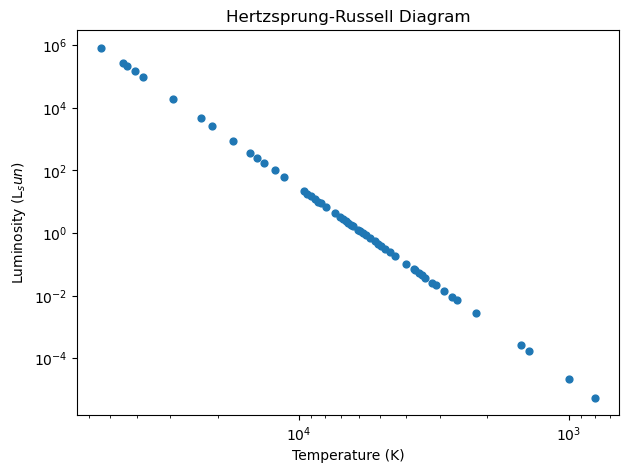

In [11]:
# PLOT THE HR DIAGRAM

T_file = '/Users/wanyan/Desktop/Astro/229/229_data/ms_mass_radius_T.dat'
T_dat  = ascii.read(T_file)

#T_dat.pprint_all()

ms_t = np.array(T_dat['Temperature_K'], dtype=float)  
ms_r = np.array(T_dat['Radius_Rsun'],  dtype=float)   

F_list = (const.sigma_sb * (ms_t * u.K)**4).to(u.W/u.m**2)


R_m   = (ms_r * const.R_sun).to(u.m)
L     = (4 * np.pi * R_m**2 * F_list).to(u.W)
L_over_Lsun_list = ((L / const.L_sun)
                    .to(u.dimensionless_unscaled)
                    .value.tolist())

#print(L_over_Lsun_list)


plt.figure(figsize=(7,5))
plt.scatter(ms_t, L_over_Lsun_list, s=24)
plt.xscale('log'); plt.yscale('log')
plt.gca().invert_xaxis()                 
plt.xlabel('Temperature (K)')
plt.ylabel('Luminosity (L$_sun$)')
plt.title('Hertzsprung-Russell Diagram')
plt.show()


## Part 2: Predictions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy

from astropy.io import fits
from astropy.table import Table
import astropy.constants as const
import astropy.units as u

from PyAstronomy import pyasl

tcs = pyasl.TransmissionCurves()

In [11]:
tcs.availableBands()

['Bessel b',
 'Bessel i',
 'Bessel r',
 'Bessel u',
 'Bessel v',
 'Gaia_DR3_G',
 'Gaia_DR3_G_BP',
 'Gaia_DR3_G_RP',
 'Johnson B',
 'Johnson U',
 'Johnson V']

In [12]:
vdata = tcs.getTransCurveData('Bessel v')
print(vdata)

[[4.70e+03 0.00e+00]
 [4.80e+03 3.00e-02]
 [4.90e+03 1.63e-01]
 [5.00e+03 4.58e-01]
 [5.10e+03 7.80e-01]
 [5.20e+03 9.67e-01]
 [5.30e+03 1.00e+00]
 [5.40e+03 9.73e-01]
 [5.50e+03 8.98e-01]
 [5.60e+03 7.92e-01]
 [5.70e+03 6.84e-01]
 [5.80e+03 5.74e-01]
 [5.90e+03 4.61e-01]
 [6.00e+03 3.59e-01]
 [6.10e+03 2.70e-01]
 [6.20e+03 1.97e-01]
 [6.30e+03 1.35e-01]
 [6.40e+03 8.10e-02]
 [6.50e+03 4.50e-02]
 [6.60e+03 2.50e-02]
 [6.70e+03 1.70e-02]
 [6.80e+03 1.30e-02]
 [6.90e+03 9.00e-03]
 [7.00e+03 0.00e+00]]


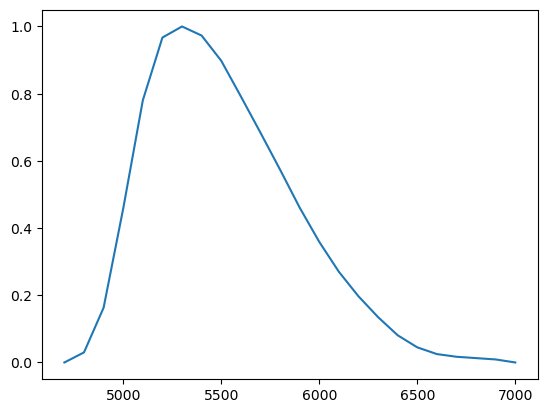

In [14]:
plt.plot(vdata[:,0], vdata[:,1])

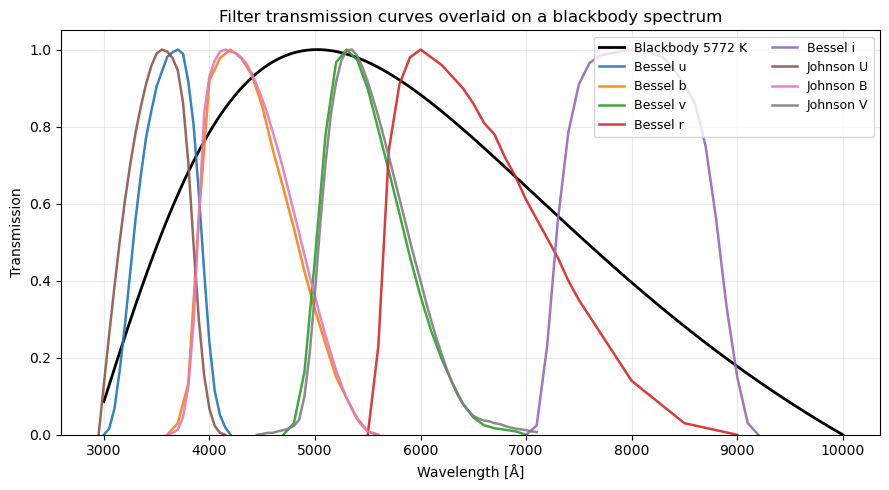

In [18]:
# constants
h = const.h.value
c = const.c.value
k_B = const.k_B.value

def planck_lambda(wavelength_angstroms, temperature_K):
  wavelength_m = wavelength_angstroms * 1e-10
  a = 2.0 * h * c**2 / (wavelength_m**5)
  b = (h * c) / (wavelength_m * k_B * temperature_K)
  return a / (np.exp(b) - 1.0)

T = 5772

lam = np.linspace(3000, 10000, 6000)

I = planck_lambda(lam, T)
I_norm = (I - I.min()) / (I.max() - I.min())

preferred_bands = [
  'Bessel u', 'Bessel b', 'Bessel v', 'Bessel r', 'Bessel i',
  'Johnson U', 'Johnson B', 'Johnson V'
]
available = set(tcs.availableBands())
bands = [b for b in preferred_bands if b in available]

plt.figure(figsize=(9, 5))
plt.plot(lam, I_norm, color='k', lw=2, label=f'Blackbody {T} K')

# Overlay
for band in bands:
  data = tcs.getTransCurveData(band)
  plt.plot(data[:, 0], data[:, 1], lw=1.8, label=band, alpha=0.9)

plt.xlabel('Wavelength [Å]')
plt.ylabel('Transmission')
plt.ylim(0, 1.05)
plt.title('Filter transmission curves overlaid on a blackbody spectrum')
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [23]:
# Convolution
lambdas = np.linspace(3000, 10000, 6000)
sun = planck_lambda(lambdas, 5772)

usun = tcs.convolveWith(lambdas, sun, 'Bessel u')
bsun = tcs.convolveWith(lambdas, sun, 'Bessel b')
vsun = tcs.convolveWith(lambdas, sun, 'Bessel v')
rsun = tcs.convolveWith(lambdas, sun, 'Bessel r')
isun = tcs.convolveWith(lambdas, sun, 'Bessel i')

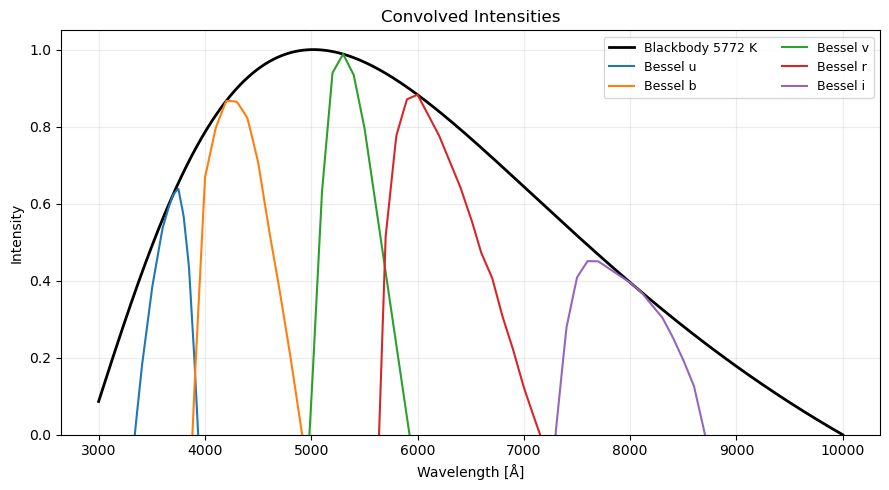

In [24]:
# Normalize to overlay with the original blackbody
sun_min, sun_ptp = sun.min(), sun.ptp()
sun_norm = (sun - sun_min) / sun_ptp
u_norm = (usun - sun_min) / sun_ptp
b_norm = (bsun - sun_min) / sun_ptp
v_norm = (vsun - sun_min) / sun_ptp
r_norm = (rsun - sun_min) / sun_ptp
i_norm = (isun - sun_min) / sun_ptp

plt.figure(figsize=(9,5))
plt.plot(lambdas, sun_norm, 'k', lw=2, label='Blackbody 5772 K')
plt.plot(lambdas, u_norm, label='Bessel u')
plt.plot(lambdas, b_norm, label='Bessel b')
plt.plot(lambdas, v_norm, label='Bessel v')
plt.plot(lambdas, r_norm, label='Bessel r')
plt.plot(lambdas, i_norm, label='Bessel i')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Intensity')
plt.ylim(0, 1.05)
plt.title('Convolved Intensities')
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [32]:
# Magnitude from Flux Calculated

def magnitude_from_flux(flux, constant=0.0, clip_tiny=True):
    flux = np.asarray(flux, dtype=float)
    if clip_tiny:
        flux = np.clip(flux, np.finfo(float).tiny, None)
    elif np.any(flux <= 0):
        raise ValueError("Flux must be positive.")
    return -2.5 * np.log10(flux) + constant
    

bsun = tcs.convolveWith(lambdas, sun, 'Bessel b')
vsun = tcs.convolveWith(lambdas, sun, 'Bessel v')

F_B = np.trapz(bsun, lambdas)
F_V = np.trapz(vsun, lambdas)

m_B = magnitude_from_flux(F_B, constant=0.0)
m_V = magnitude_from_flux(F_V, constant=0.0)

print(f"apparent magnitude in B band = {m_B:.4f}")
print(f"apparent magnitude in V band = {m_V:.4f}")

apparent magnitude in B band = -40.9361
apparent magnitude in V band = -40.8941


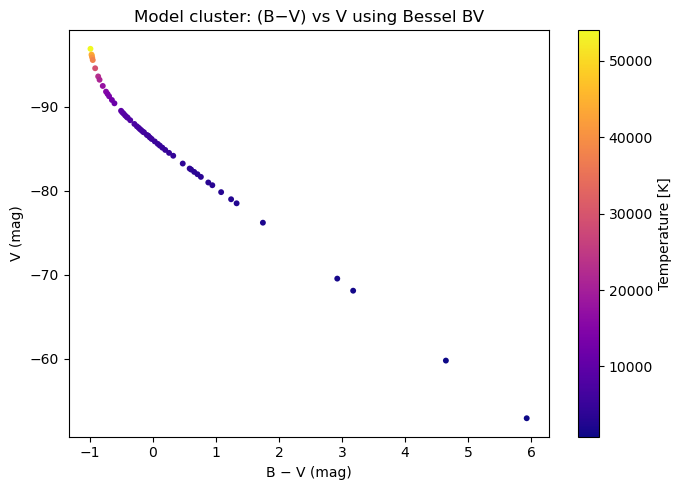

In [34]:
from pathlib import Path
from astropy.io import ascii

T_file = '/Users/wanyan/Desktop/Astro/229/229_data/ms_mass_radius_T.dat'
T_dat  = ascii.read(T_file)
ms_t = np.array(T_dat['Temperature_K'], dtype=float)
ms_r = np.array(T_dat['Radius_Rsun'],  dtype=float)


lambdas = np.linspace(3000, 10000, 6000)

F_B_surface = []
F_V_surface = []
for T in ms_t:
    B_lam = planck_lambda(lambdas, T)
    B_conv = tcs.convolveWith(lambdas, B_lam, 'Bessel b')
    V_conv = tcs.convolveWith(lambdas, B_lam, 'Bessel v')
    F_B_surface.append(np.trapz(B_conv, lambdas))
    F_V_surface.append(np.trapz(V_conv, lambdas))

F_B_surface = np.array(F_B_surface)
F_V_surface = np.array(F_V_surface)

d = 1.0 * u.kpc
geom = (R_m / d)**2
F_B = np.pi * F_B_surface * geom.value
F_V = np.pi * F_V_surface * geom.value

m_B = magnitude_from_flux(F_B, constant=0.0)
m_V = magnitude_from_flux(F_V, constant=0.0)
B_minus_V = m_B - m_V

plt.figure(figsize=(7,5))
plt.scatter(B_minus_V, m_V, s=18, c=ms_t, cmap='plasma', edgecolors='none')
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature [K]')
plt.xlabel('B − V (mag)')
plt.ylabel('V (mag)')
plt.title('Model cluster: (B−V) vs V using Bessel BV')
plt.tight_layout()
plt.show()